# **Employee Churn Predictor - ML Process**

## Context

TechNova Solutions, a mid-sized IT services company with ~1,200 employees, has been facing an attrition rate well above industry standards. Despite offering competitive salaries and benefits, the company struggles to retain talent, particularly in technical and client-facing roles. This turnover has increased costs, delayed projects, and reduced overall employee satisfaction.  

The Employee Churn Predictor is intended to predict whether an employee is about to leave the company by implementing classification models trained on historical data. A secondary goal is to identify key factors that contribute to churn, enabling the company to design targeted strategies that improve employee retention.

In practice, the system will generate churn probability scores for individual employees and highlight the most influential factors driving attrition. These insights will be provided to HR and management teams, enabling proactive retention measures such as targeted engagement programs, career development opportunities, or workload adjustments. Over time, the solution can be scaled into an integrated HR analytics dashboard, supporting continuous monitoring of employee retention trends and helping the company reduce costs and improve workforce stability.

## Problem Statement

TechNova Solutions is experiencing an employee attrition rate that exceeds industry standards, particularly among technical and client-facing roles. This high turnover increases recruitment and training costs, delays project delivery, and negatively impacts employee morale. The company currently lacks a data-driven mechanism to anticipate which employees are at risk of leaving and to identify the main factors driving this behavior.

## Objectives & Scope

- Identify the most relevant factors that contribute to employee attrition.
- Build a predictive model that can classify whether an employee is likely to leave with a Recall above 85%.
- Provide actionable recommendations that can help HR improve retention and employee satisfaction.

> Requirements not mentioned in this section are out of the scope, however, future stages are proposed below as future work for this especification.

## Data Understanding

In [2]:
# Import libraries required for the analysis
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# Load dataset
df = pd.read_csv('data/employee_churn_dataset.csv', sep=',', index_col=False, header = 0)
print(f'Dataset Shape: {df.shape}')
df.head(10)

Dataset Shape: (10000, 22)


,Employee ID,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Work-Life Balance,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Churn
0,E00001,50,Male,Bachelor's,Married,5,Analyst,Marketing,93422,Remote,5,37,35,0,16,0.03,Poor,155,14,15,7.9,0
1,E00002,36,Male,Bachelor's,Married,4,Manager,Sales,44589,On-site,2,43,1,0,12,0.39,Average,162,2,8,5.2,0
2,E00003,29,Male,Bachelor's,Married,3,Sales,IT,56768,Hybrid,1,38,41,0,2,0.62,Poor,243,6,21,6.3,0
3,E00004,42,Male,Bachelor's,Single,12,Analyst,Sales,79009,On-site,1,39,33,0,8,0.73,Good,291,11,25,7.4,0
4,E00005,40,Other,Bachelor's,Married,1,Sales,HR,81982,On-site,3,49,30,0,13,0.52,Average,272,3,1,4.1,0
5,E00006,44,Male,Bachelor's,Single,12,Developer,HR,82669,On-site,2,4,68,0,2,0.06,Average,266,4,40,2.1,0
6,E00007,32,Male,High School,Married,12,Analyst,Marketing,127951,On-site,1,37,19,0,35,0.76,Average,233,10,10,4.9,0
7,E00008,32,Male,Master's,Single,6,Manager,Sales,93655,Remote,1,48,37,0,19,0.39,Average,204,1,14,7.3,0
8,E00009,45,Female,Master's,Single,4,Analyst,Sales,69050,Remote,3,12,74,0,45,0.18,Excellent,162,15,36,4.9,1
9,E00010,57,Male,High School,Married,12,Developer,Marketing,106153,Hybrid,3,14,94,0,17,0.26,Good,151,19,27,4.7,0


In [4]:
# Check for datatypes, null-values and columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Employee ID                   10000 non-null  object 
 1   Age                           10000 non-null  int64  
 2   Gender                        10000 non-null  object 
 3   Education Level               10000 non-null  object 
 4   Marital Status                10000 non-null  object 
 5   Tenure                        10000 non-null  int64  
 6   Job Role                      10000 non-null  object 
 7   Department                    10000 non-null  object 
 8   Salary                        10000 non-null  int64  
 9   Work Location                 10000 non-null  object 
 10  Performance Rating            10000 non-null  int64  
 11  Projects Completed            10000 non-null  int64  
 12  Training Hours                10000 non-null  int64  
 13  Pr

In [4]:
#Check missing values
missing_values = df.isna().sum()
# print(type(missing_values.iloc[0]))
missing_values_percentage = (df.isna().mean()*100).apply(lambda x: (f"{x:.1f}%"))
missing_df = pd.DataFrame({'Missing' : missing_values, 
                           '% Missing' : missing_values_percentage
                           })
missing_df

,Missing,% Missing
Employee ID,0,0.0%
Age,0,0.0%
Gender,0,0.0%
Education Level,0,0.0%
Marital Status,0,0.0%
Tenure,0,0.0%
Job Role,0,0.0%
Department,0,0.0%
Salary,0,0.0%
Work Location,0,0.0%


The dataset contains 10,000 records corresponding to TechNova's employees and historical data. It includes 22 features, such as Employee ID, Age, Gender, Education Level, Marital Status, Tenure, Job Role, Department, Salary, Work Location, Performance Rating, Projects Completed, Training Hours, Promotions, Overtime Hours, Satisfaction Level, Work-Life Balance, Average Monthly Hours Worked, Absenteeism, Distance from Home, Manager Feedback Score, and Churn.

Data types vary across features. Continuous numeric features include Salary, Satisfaction Level, and Manager Feedback Score, while discrete numeric features include Age, Tenure, Performance Rating, Projects Completed, Training Hours, Promotions, Overtime Hours, Average Monthly Hours Worked, Absenteeism, Distance from Home, and Churn. Ordinal categorical features include Work-Life Balance, and nominal categorical features include Employee ID, Gender, Education Level, Marital Status, Job Role, Department, and Work Location.

The dataset contains no missing values, ensuring completeness for analysis and model training. The Churn column serves as the target variable for predicting employee attrition.


## Exploratory Data Analysis

### Univariate Analysis

#### Outcome variable

In [5]:
# Check the outcome balance. Determine the relative frequency of people who stay or leave.
class_churn = ((df.groupby('Churn').aggregate({'Churn':'count'})/df.shape[0])*100)
class_churn_percentage = class_churn.map(lambda x: f'{x:.2f}%')
class_churn_percentage

,Churn
Churn,
0,79.72%
1,20.28%


<function matplotlib.pyplot.show(close=None, block=None)>

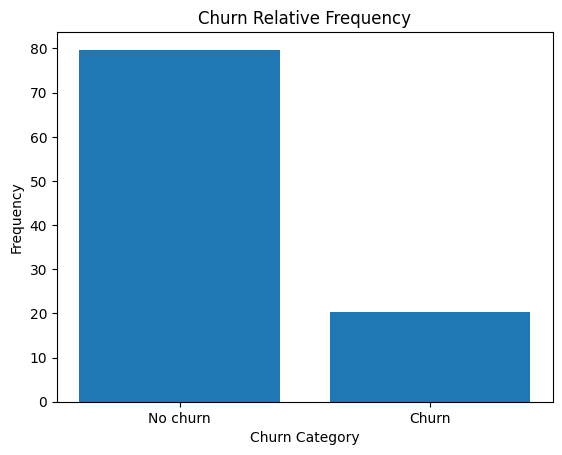

In [6]:
# Plot the outcome feature. Check for class balance

plt.bar(x=class_churn.index.tolist(), height=class_churn['Churn'] )
plt.title('Churn Relative Frequency')
plt.xlabel('Churn Category')
plt.ylabel('Frequency')
plt.xticks(ticks=[0,1], labels=['No churn', 'Churn'])
plt.show

The outcome variable which is Churn, in the figure above, shows a moderate class imbalance. In this context are class imbalance is considered moderate when the minor category is between 10%-30%, severe when it is lower than 5%, and balanced between 40-60%. This analysis will be considered for decision_making in further steps like model parameters configuration.  

In [10]:
df.describe()

,Age,Tenure,Salary,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Churn
count,10000.000000,10000.000000,10000.0000,10000.0000,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,40.561200,6.976800,89772.7548,3.0275,24.501200,49.715500,0.101000,24.2506,0.494940,224.53820,9.467700,24.491800,5.565430,0.202800
std,10.876483,4.296988,34469.8058,1.4120,14.444461,28.930822,0.301344,14.4787,0.287771,43.62834,5.758635,14.512491,2.595523,0.402105
min,22.000000,0.000000,30010.0000,1.0000,0.000000,0.000000,0.000000,0.0000,0.000000,150.00000,0.000000,0.000000,1.000000,0.000000
25%,31.000000,3.000000,59718.5000,2.0000,12.000000,24.750000,0.000000,12.0000,0.247500,186.00000,4.000000,12.000000,3.300000,0.000000
50%,41.000000,7.000000,89243.0000,3.0000,24.000000,49.000000,0.000000,24.0000,0.490000,225.00000,9.000000,24.000000,5.600000,0.000000
75%,50.000000,11.000000,119725.5000,4.0000,37.000000,75.000000,0.000000,37.0000,0.740000,262.25000,14.000000,37.000000,7.800000,0.000000
max,59.000000,14.000000,149993.0000,5.0000,49.000000,99.000000,1.000000,49.0000,1.000000,299.00000,19.000000,49.000000,10.000000,1.000000


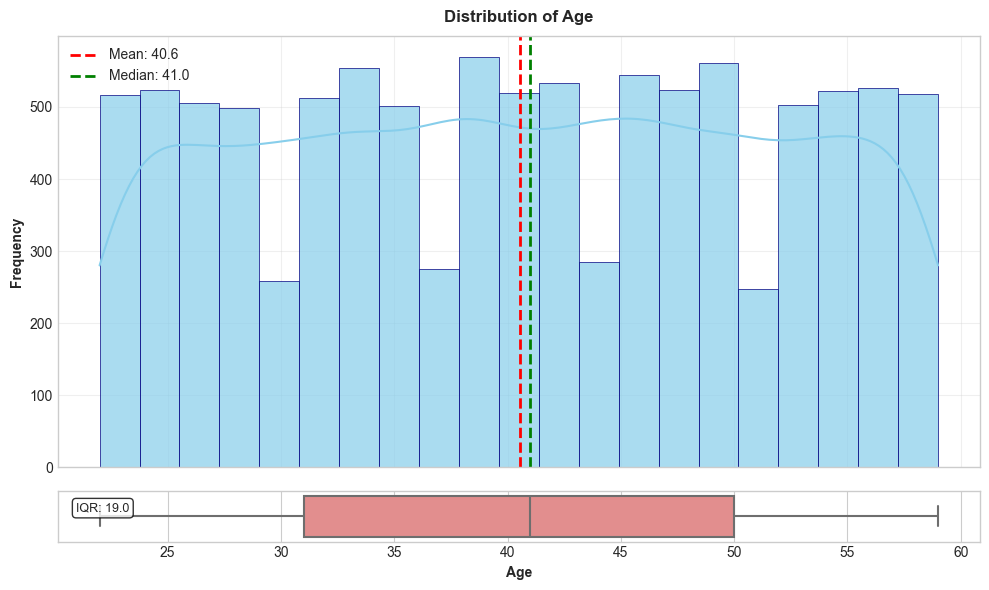

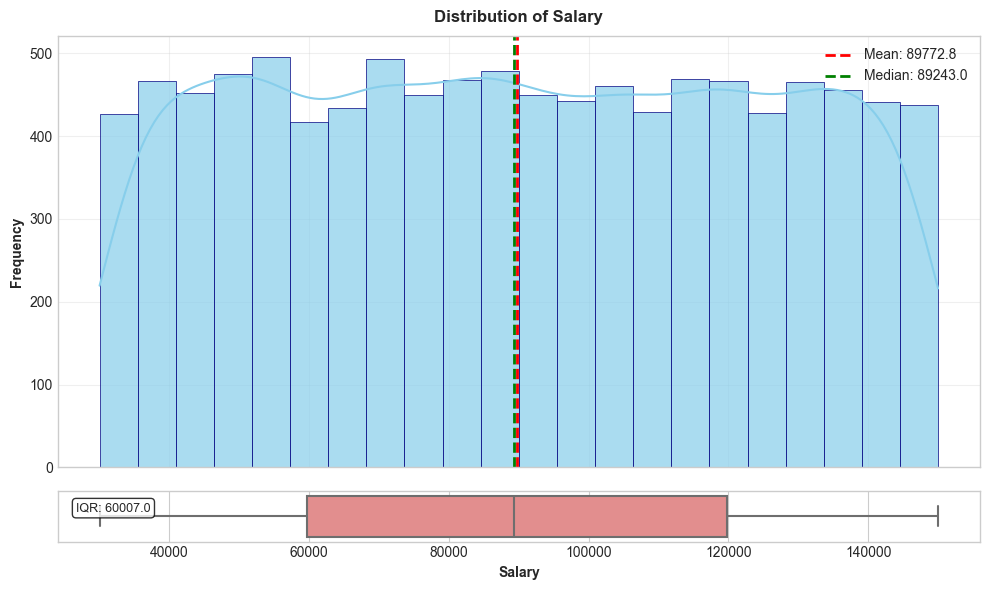

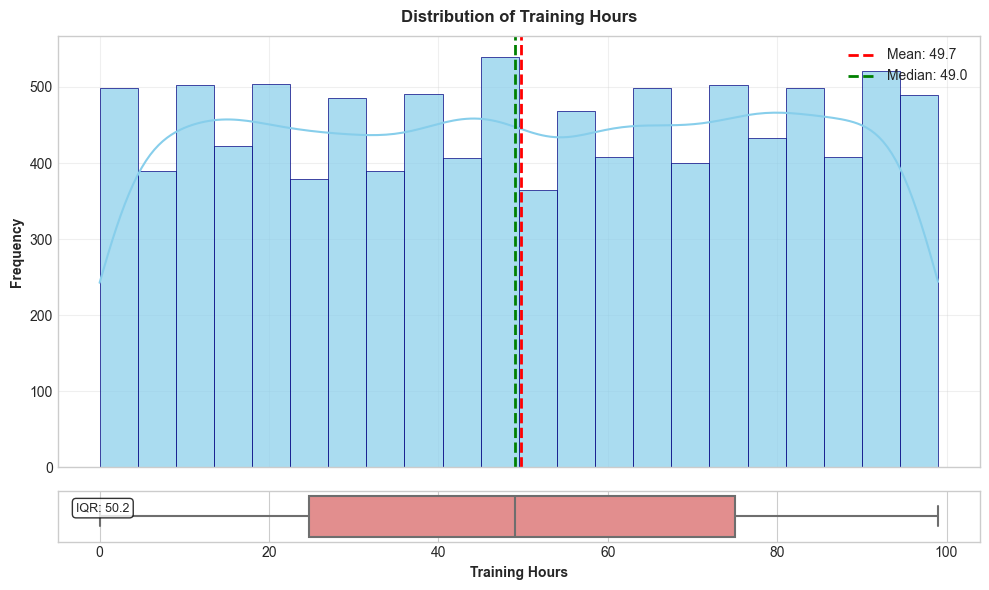

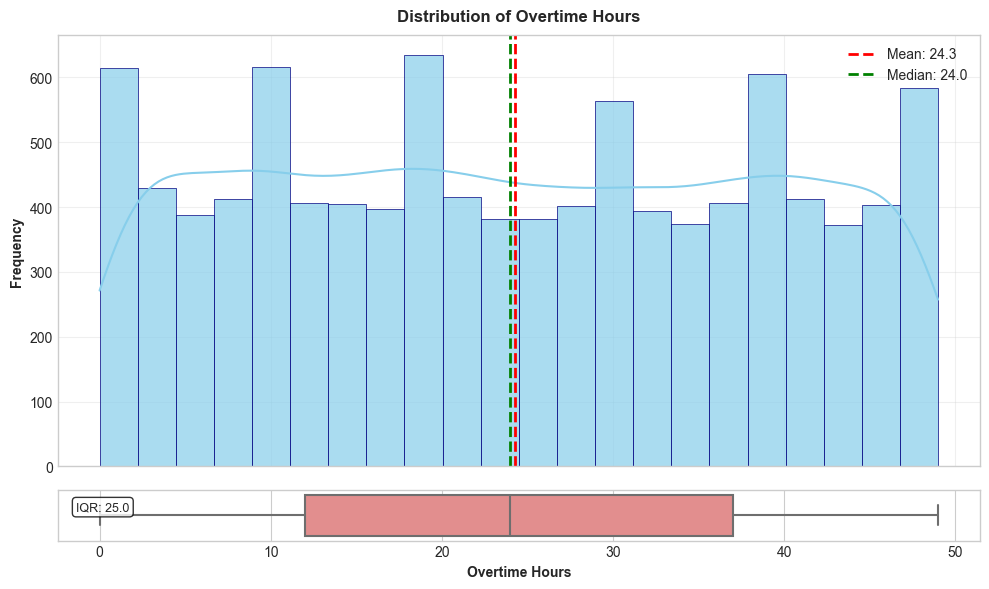

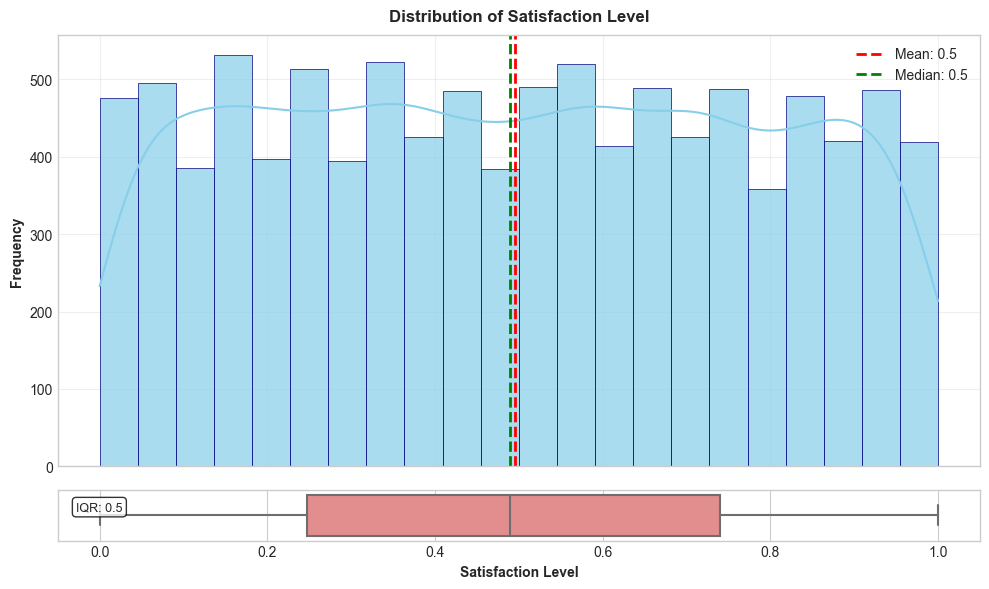

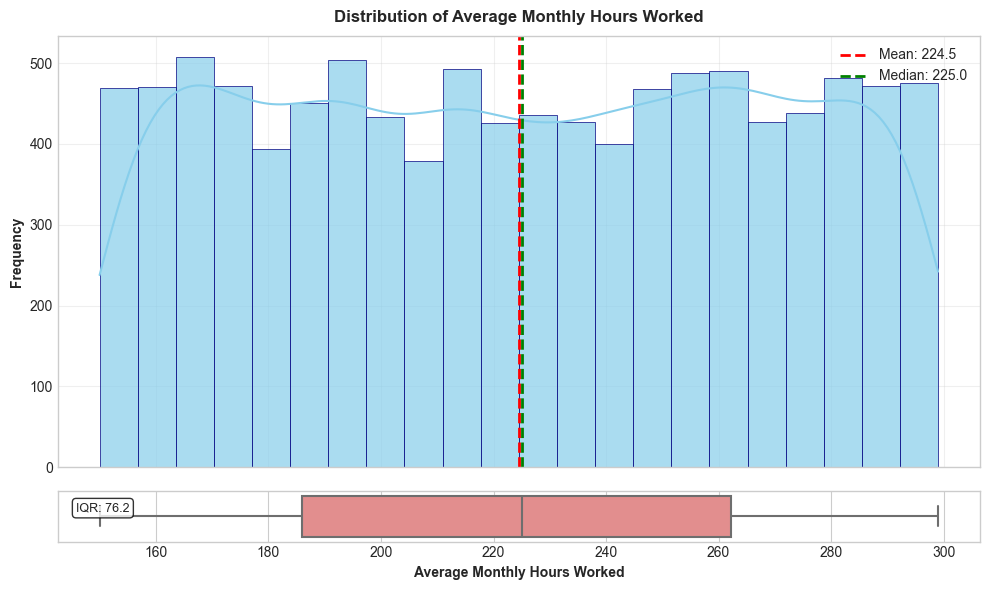

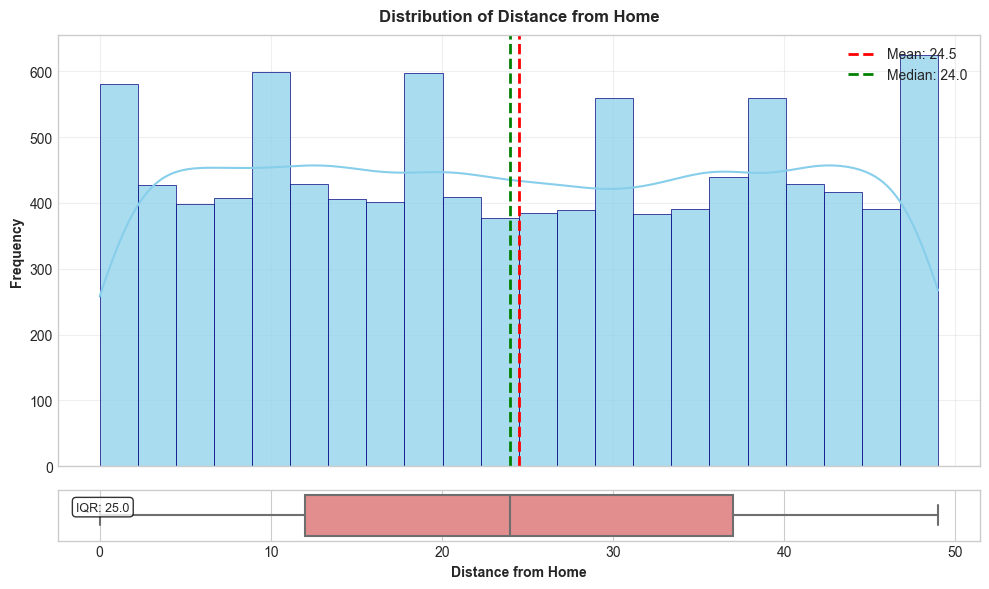

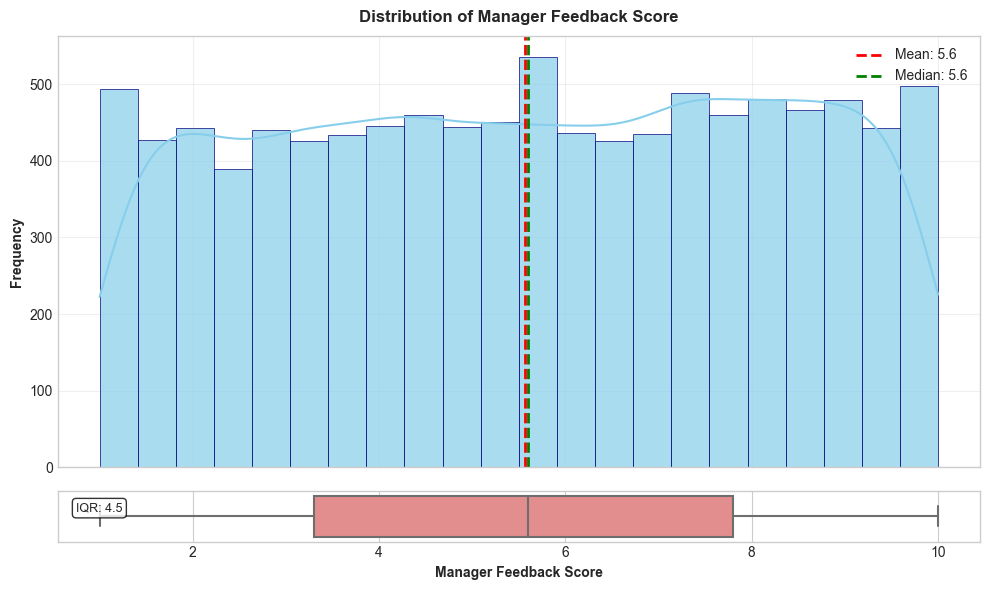

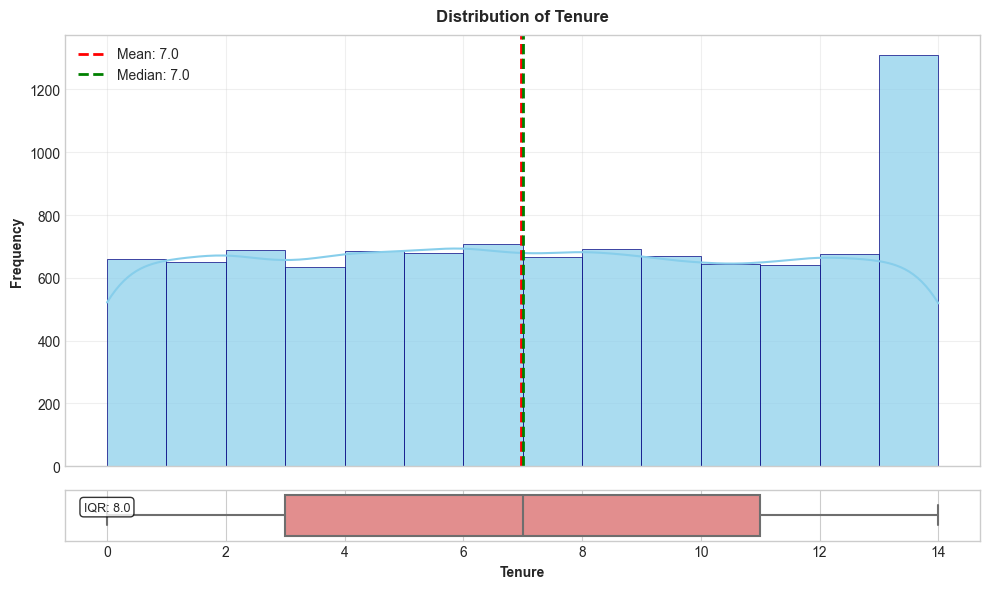

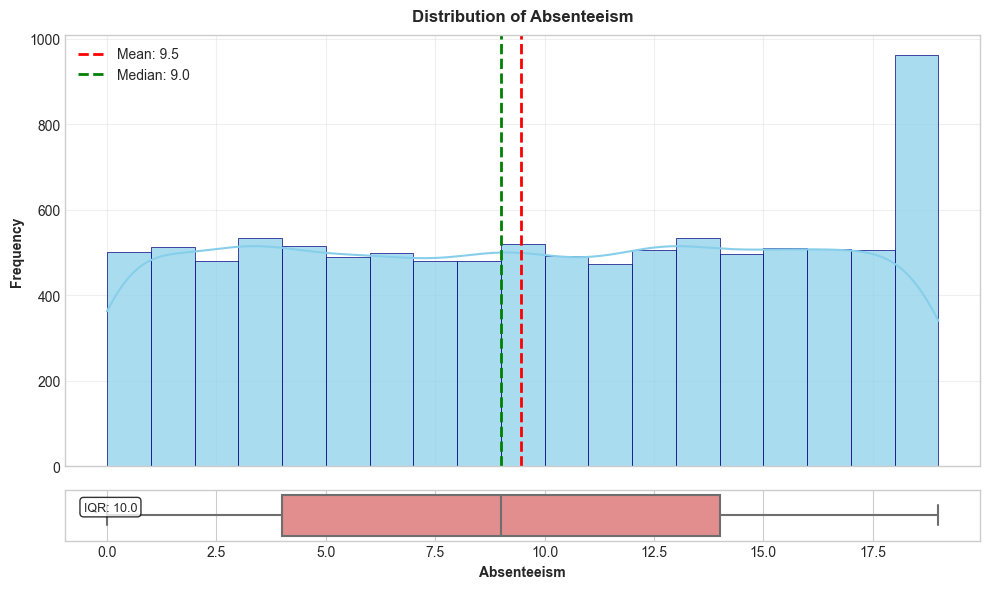

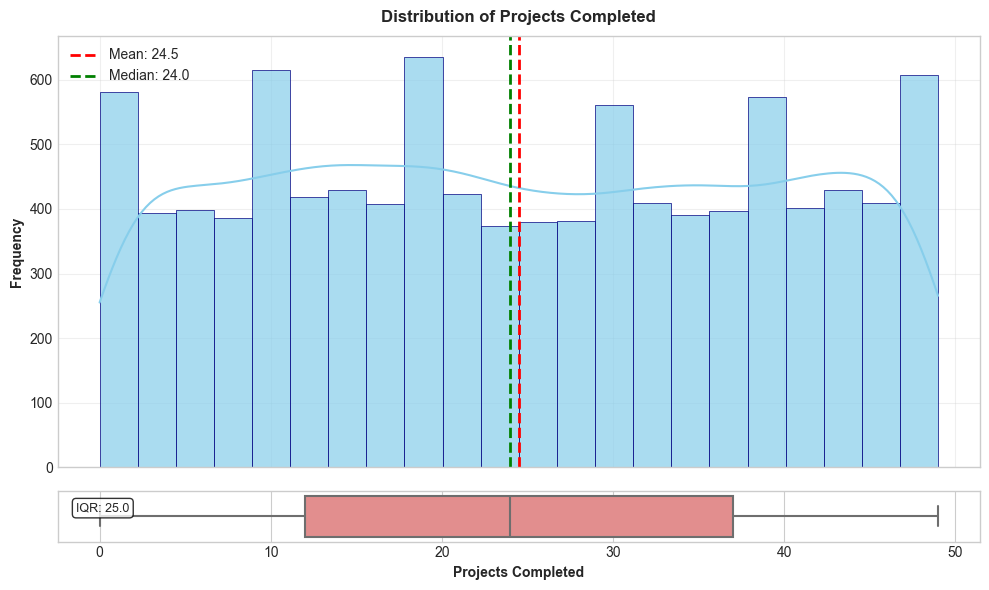

In [117]:
continuous_vars = ['Age', 'Salary', 'Training Hours', 
                   'Overtime Hours', 'Satisfaction Level', 
                   'Average Monthly Hours Worked', 'Distance from Home',
                   'Manager Feedback Score', 'Tenure', 'Absenteeism', 'Projects Completed']

for column in continuous_vars:
    
    bin_edges_fd = np.histogram_bin_edges(df[column], bins='fd')
    n_bins_fd = len(bin_edges_fd) - 1
    
    fig, (ax_hist, ax_box) = plt.subplots(
        2, 1, figsize=(10, 6), 
        gridspec_kw={"height_ratios": (0.85, 0.1)}, 
        sharex=True
    )
    
    sns.histplot(df[column], bins=n_bins_fd, kde=True, ax=ax_hist, 
                 alpha=0.7, color='skyblue', edgecolor='navy', linewidth=0.5)
    
    # Add mean and median lines 
    mean_val = df[column].mean()
    median_val = df[column].median()
    
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax_hist.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    
    ax_hist.legend()
    ax_hist.set_ylabel('Frequency', fontweight='bold')
    ax_hist.grid(True, alpha=0.3)
    ax_hist.set_title(f'Distribution of {column}', fontweight='bold', pad=10)
    
    sns.boxplot(x=df[column], ax=ax_box, color='lightcoral', linewidth=1.5)
    ax_box.set_xlabel(column, fontweight='bold')
    ax_box.set_yticks([])
    
    # Add boxplot statistics 
    q1, q3 = df[column].quantile([0.25, 0.75])
    iqr = q3 - q1
    ax_box.text(0.02, 0.6, f'IQR: {iqr:.1f}', transform=ax_box.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                fontsize=9)
    
    plt.tight_layout()
    plt.show()

Given the analysis and the provided charts, one important observation to add could be the potential implications of the multimodal distributions across most features. This suggests that the dataset might contain distinct subgroups within the employee population, which could be significant for further investigation. For instance:

- Subgroup Analysis: The multimodal nature of features like Age, Projects Completed, Satisfaction Level, Distance from Home, Overtime Hours, Average Monthly Hours Worked, and Training Hours indicates possible clusters (e.g., different departments, roles, or work patterns). This could be explored to understand if these subgroups correlate with other variables like performance or retention.

- Symmetry and Central Tendency: The close proximity of mean and median values across features (e.g., Age: 40.6 vs. 41.0, Satisfaction Level: 0.5 vs. 0.5) suggests that, within each multimodal peak, the distributions are relatively symmetric around their central tendencies. This local stability could be useful for predictive modeling or policy decisions, particularly when analyzing data segmented by these subgroups.

- IQR Variability: The varying IQR values (e.g., 19.0 for Age vs. 0.5 for Satisfaction Level) highlight differing levels of data spread. Features with a wider IQR, like Distance from Home (25.0) or Average Monthly Hours Worked (76.2), might indicate greater diversity in employee lifestyles or work habits, which could be a factor in workforce planning.

    

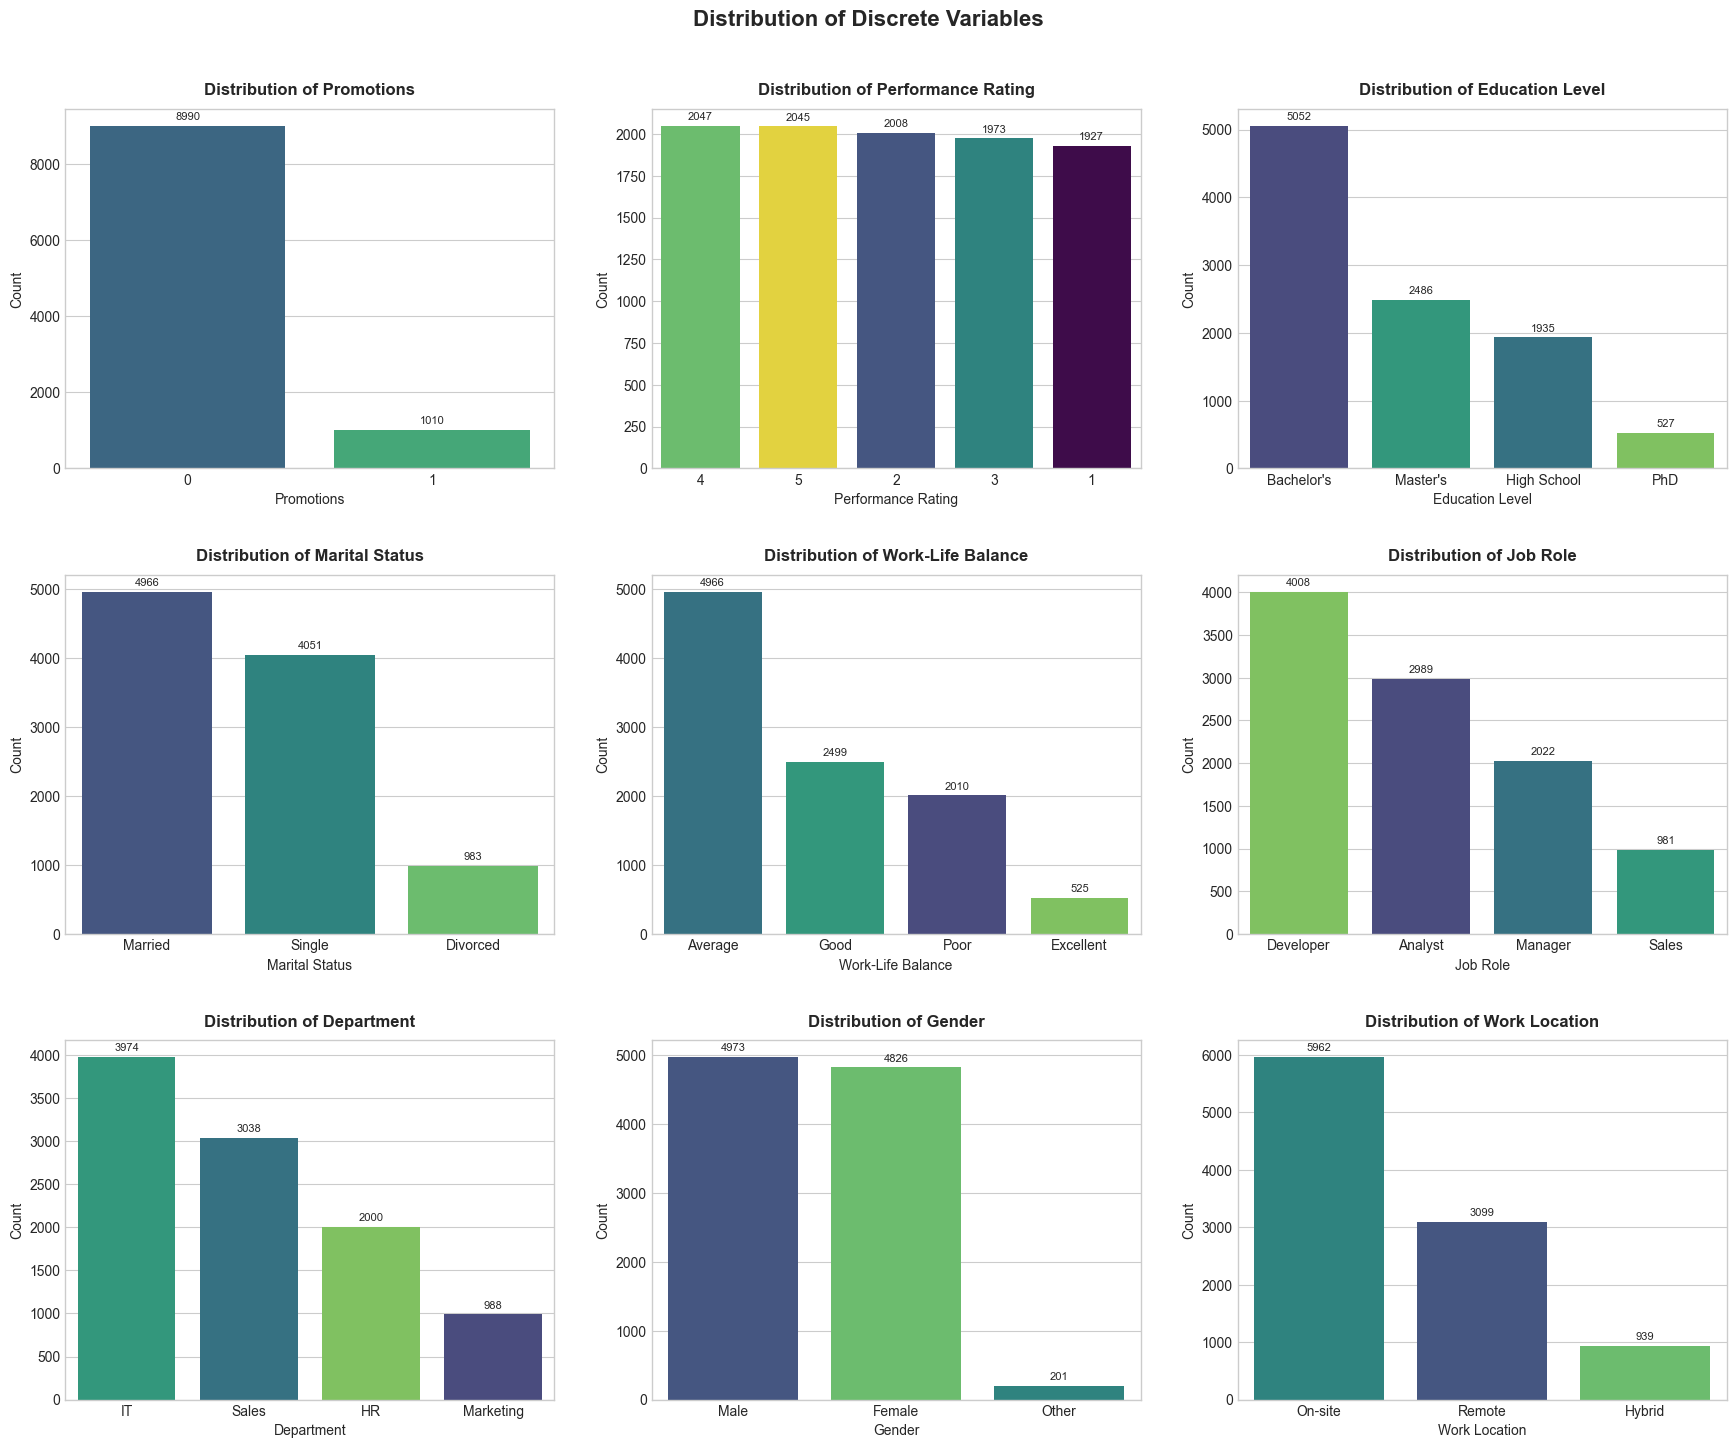

In [ ]:
# List of discrete variables for analysis
discrete = ['Promotions', 'Performance Rating', 'Education Level', 'Marital Status', 
            'Work-Life Balance', 'Job Role', 'Department', 'Gender', 'Work Location']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()  

# Plot each discrete variable in its own subplot
for i, feature in enumerate(discrete):
    # Get value counts and sort in descending order
    value_counts = df[feature].value_counts()
    order = value_counts.index
    
    # Create countplot with descending order
    sns.countplot(x=df[feature], hue=df[feature], ax=axes[i], palette='viridis', 
                  legend=False, order=order)
    
    # Set title and format
    axes[i].set_title(f'Distribution of {feature}', fontweight='bold', pad=10)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
    # Rotate x-axis labels if too many categories
    if df[feature].nunique() > 5:
        axes[i].tick_params(axis='x', rotation=45)
    
    # Add value labels on top of bars
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', padding=3, fontsize=8)

# Remove any empty subplots if discrete list has less than 9 elements
for i in range(len(discrete), len(axes)):
    fig.delaxes(axes[i])

# Main title for the entire figure with increased spacing between subplots
plt.suptitle('Distribution of Discrete Variables', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(pad=3.0)
plt.show()

Based on the analysis of the provided charts for discrete variables, the following key observations can be highlighted:

- Imbalanced Distributions Across Variables: The dataset exhibits significant imbalances in the distribution of discrete features. For instance, Promotions are heavily skewed toward 0 (8860 counts) compared to 1 (1010 counts), suggesting a low promotion rate. Similarly, Education Level shows a strong dominance of Bachelor's degrees (5052 counts) over other levels like Master's (2496 counts) or High School (1935 counts), let alone PhD.

- Dominant Categories in Key Features: Certain categories stand out within each variable. Marital Status leans heavily toward Married, with a strong presence at 4066 individuals, followed closely by Single at 4031, while Divorced is less common at 963. Performance Rating shows a clear peak at 3 with 2045 employees, reflecting a common rating level. Work-Life Balance is predominantly Average with 4066 people, with fewer rating it Excellent at 529 or Poor at 2010. Job Role is dominated by Developers at 4008, trailed by Analysts at 2909, and Managers at 2022.

- Gender and Work Location Disparities: The Gender distribution is fairly balanced between Male (4073 counts) and Female (4283 counts), with only a slight difference of 210 counts. The primary imbalance arises from the minimal representation in the "Other" category (201 counts), suggesting a significant underrepresentation of this group compared to the binary genders. This could have implications for diversity initiatives or further investigation into gender demographics within the workforce.

These imbalances and dominant categories could have implications for workforce planning, diversity initiatives, or performance evaluations. The skewed distributions suggest potential areas for targeted analysis to understand underlying factors, such as the impact of education level on job roles or the effect of work-life balance on performance ratings.

### Multivariate Analysis

#### Correlation Matrix

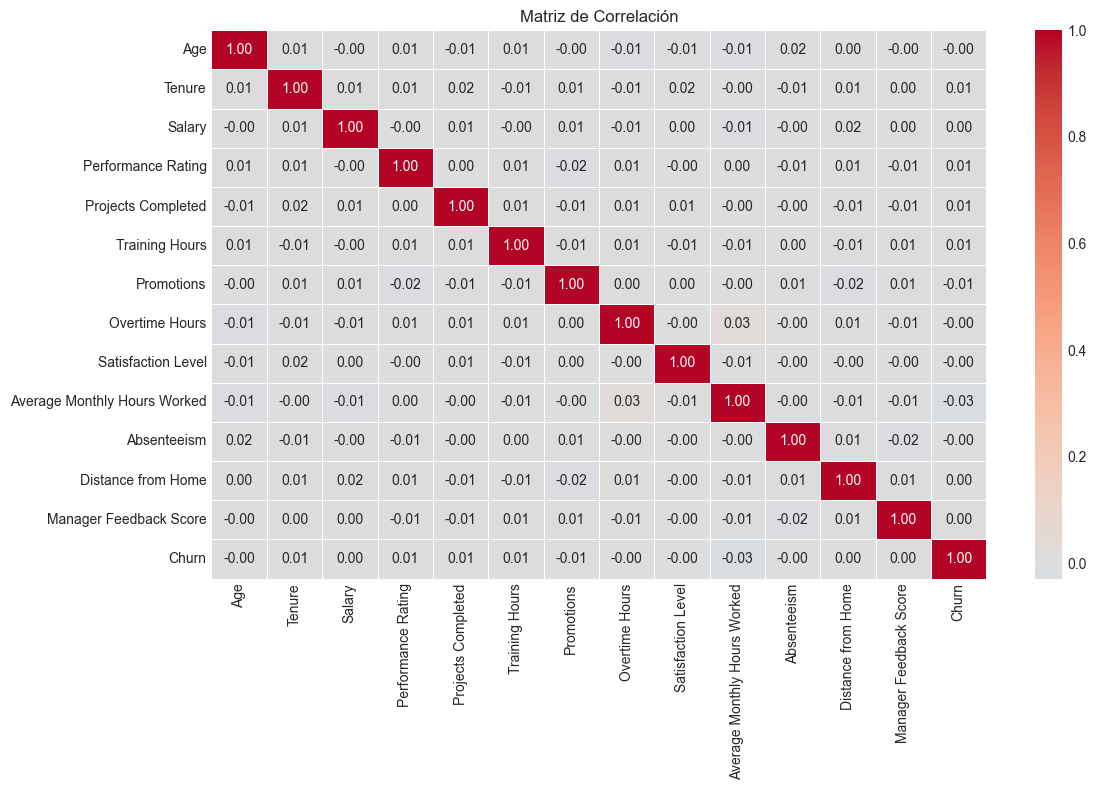

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,          
    cmap='coolwarm',    
    center=0,             
    fmt='.2f',
    linewidths=0.5
)
plt.title('Matriz de Correlación') 
plt.tight_layout()
plt.show()

The correlation matrix reveals that no individual variable exhibits a linear correlation with Churn. This suggests that employee turnover cannot be explained by a single characteristic and is likely influenced by complex interactions among multiple factors. It is recommended to proceed with non-linear models and variable importance analysis to identify the true drivers of churn. Nonetheless, a deep bivariate analysis between the outcome (Churn) and the other features will be performed in the subsequent steps to capture additional insights. 

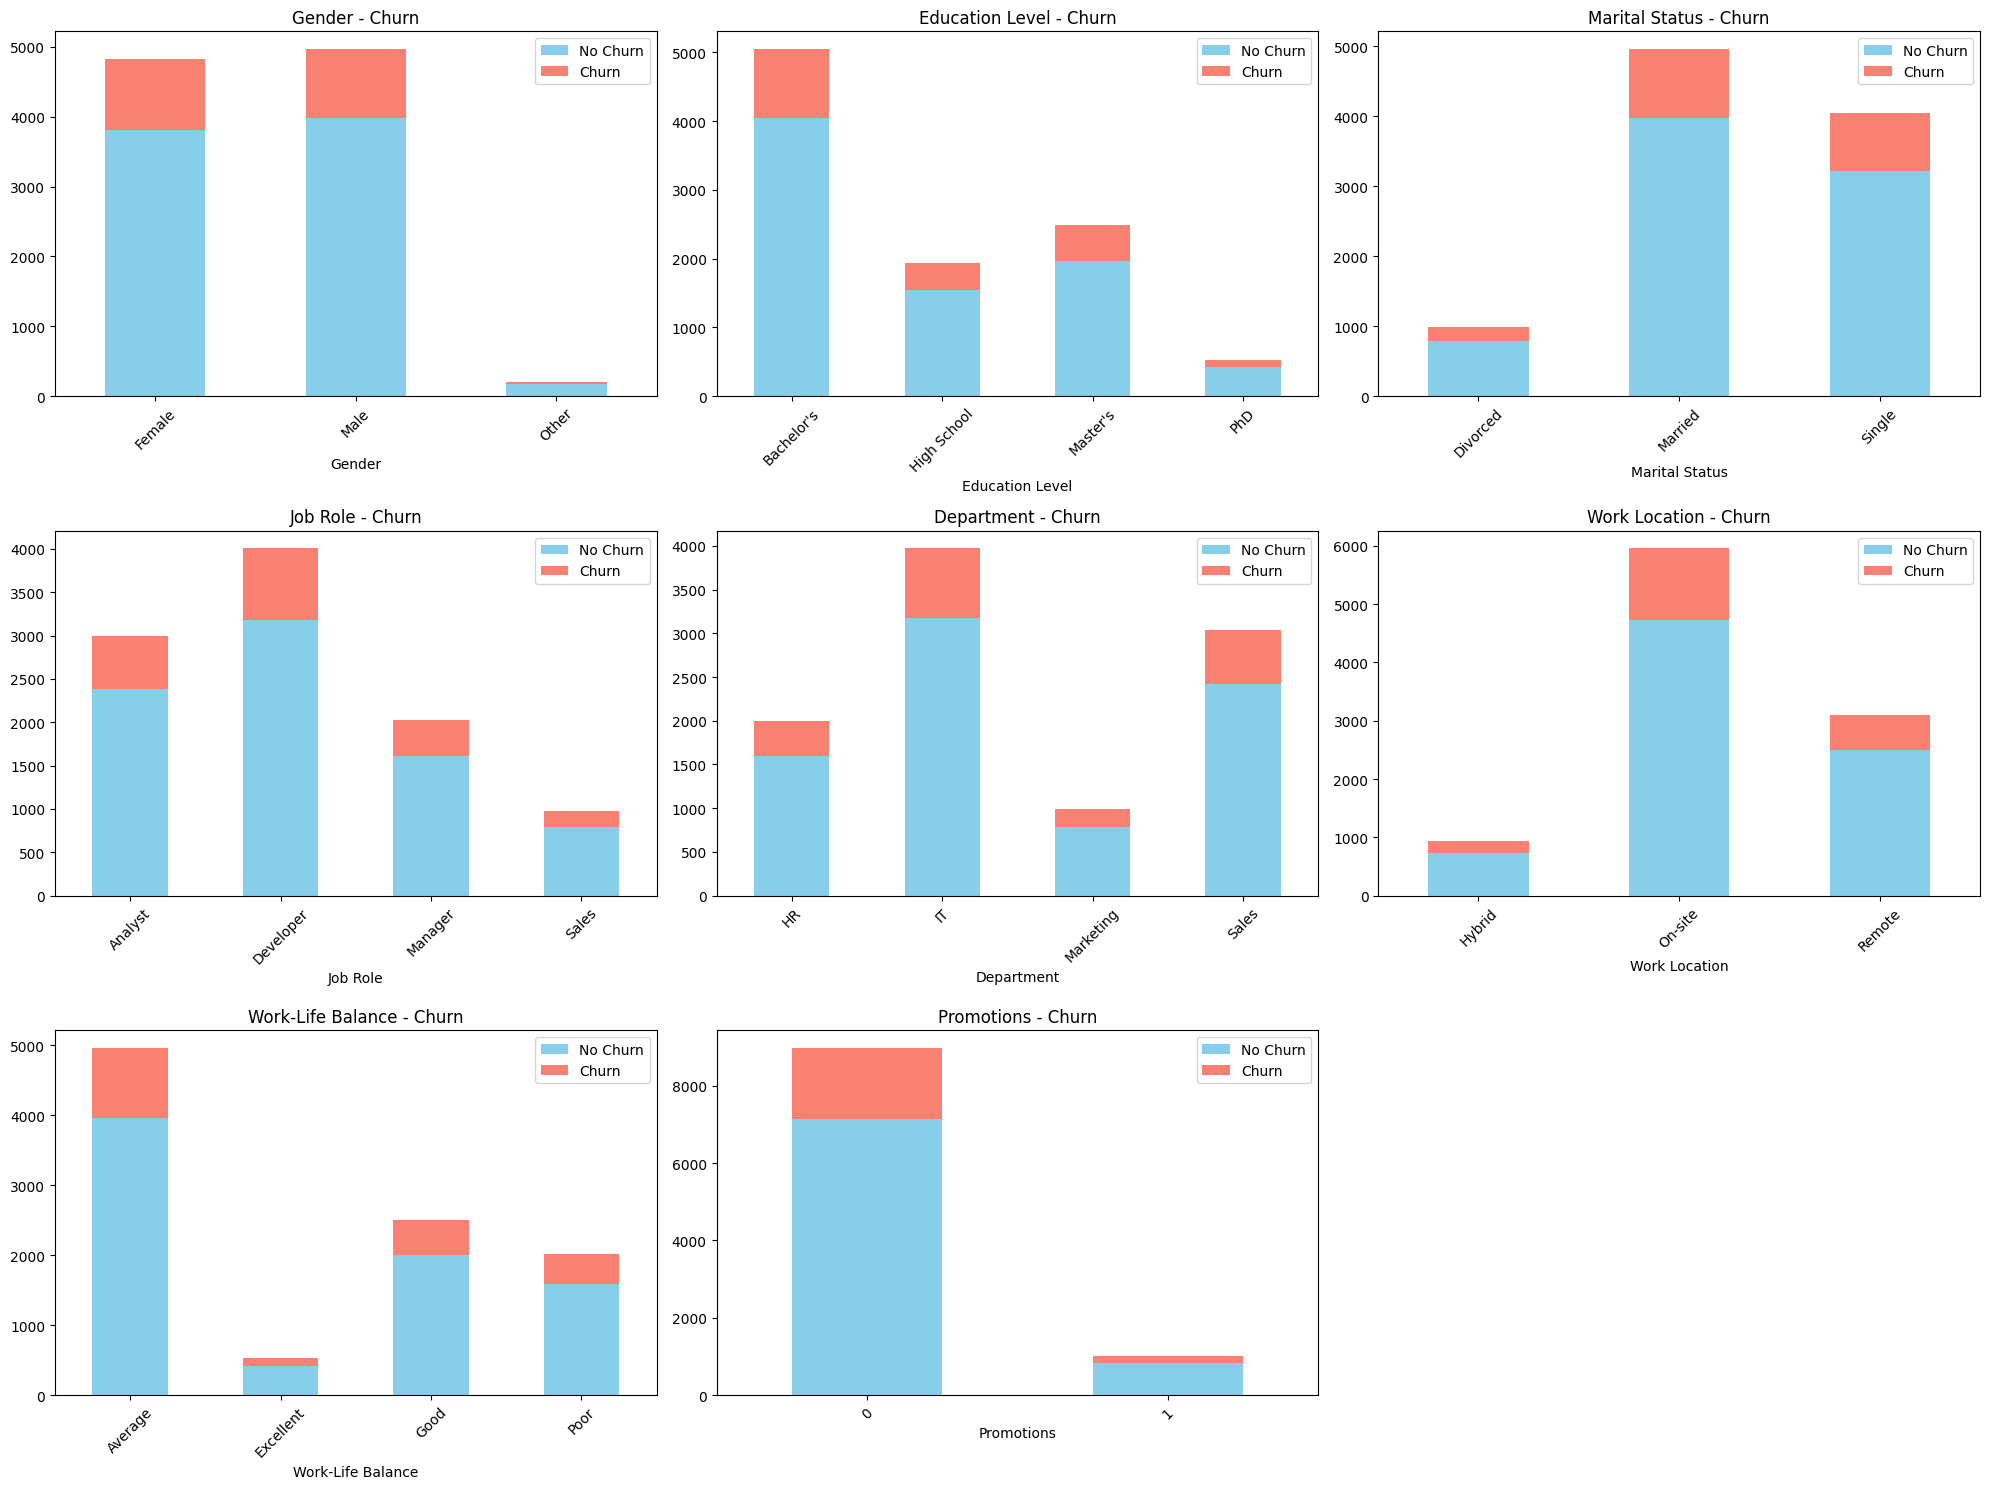

In [169]:
# Categorical features
categorical_vars = ['Gender', 'Education Level', 'Marital Status', 'Job Role', 
                   'Department', 'Work Location', 'Work-Life Balance', 'Promotions']

fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for i, var in enumerate(categorical_vars):
    row, col = i // 3, i % 3
    cross_tab = pd.crosstab(df[var], df['Churn'])
    cross_tab.plot(kind='bar', stacked=True, ax=axes[row, col], color=['skyblue', 'salmon'])
    axes[row, col].set_title(f'{var} - Churn')
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].legend(['No Churn', 'Churn'])

if len(categorical_vars) < 9:
    axes[2, 2].set_visible(False)

plt.tight_layout()
plt.show()

The bivariate analysis indicates that no single discrete variable overwhelmingly drives Churn, consistent with the earlier finding of no strong linear correlations. However, certain categories (e.g., Divorced marital status, Poor Work-Life Balance, Remote work location) exhibit slightly higher relative Churn proportions, suggesting these areas might contribute to turnover through complex interactions. Further exploration with non-linear models and variable importance analysis remains recommended to uncover the underlying drivers.

The class proportions remains steady in relation to the class churn, confirming that not valuable patterns or insights.

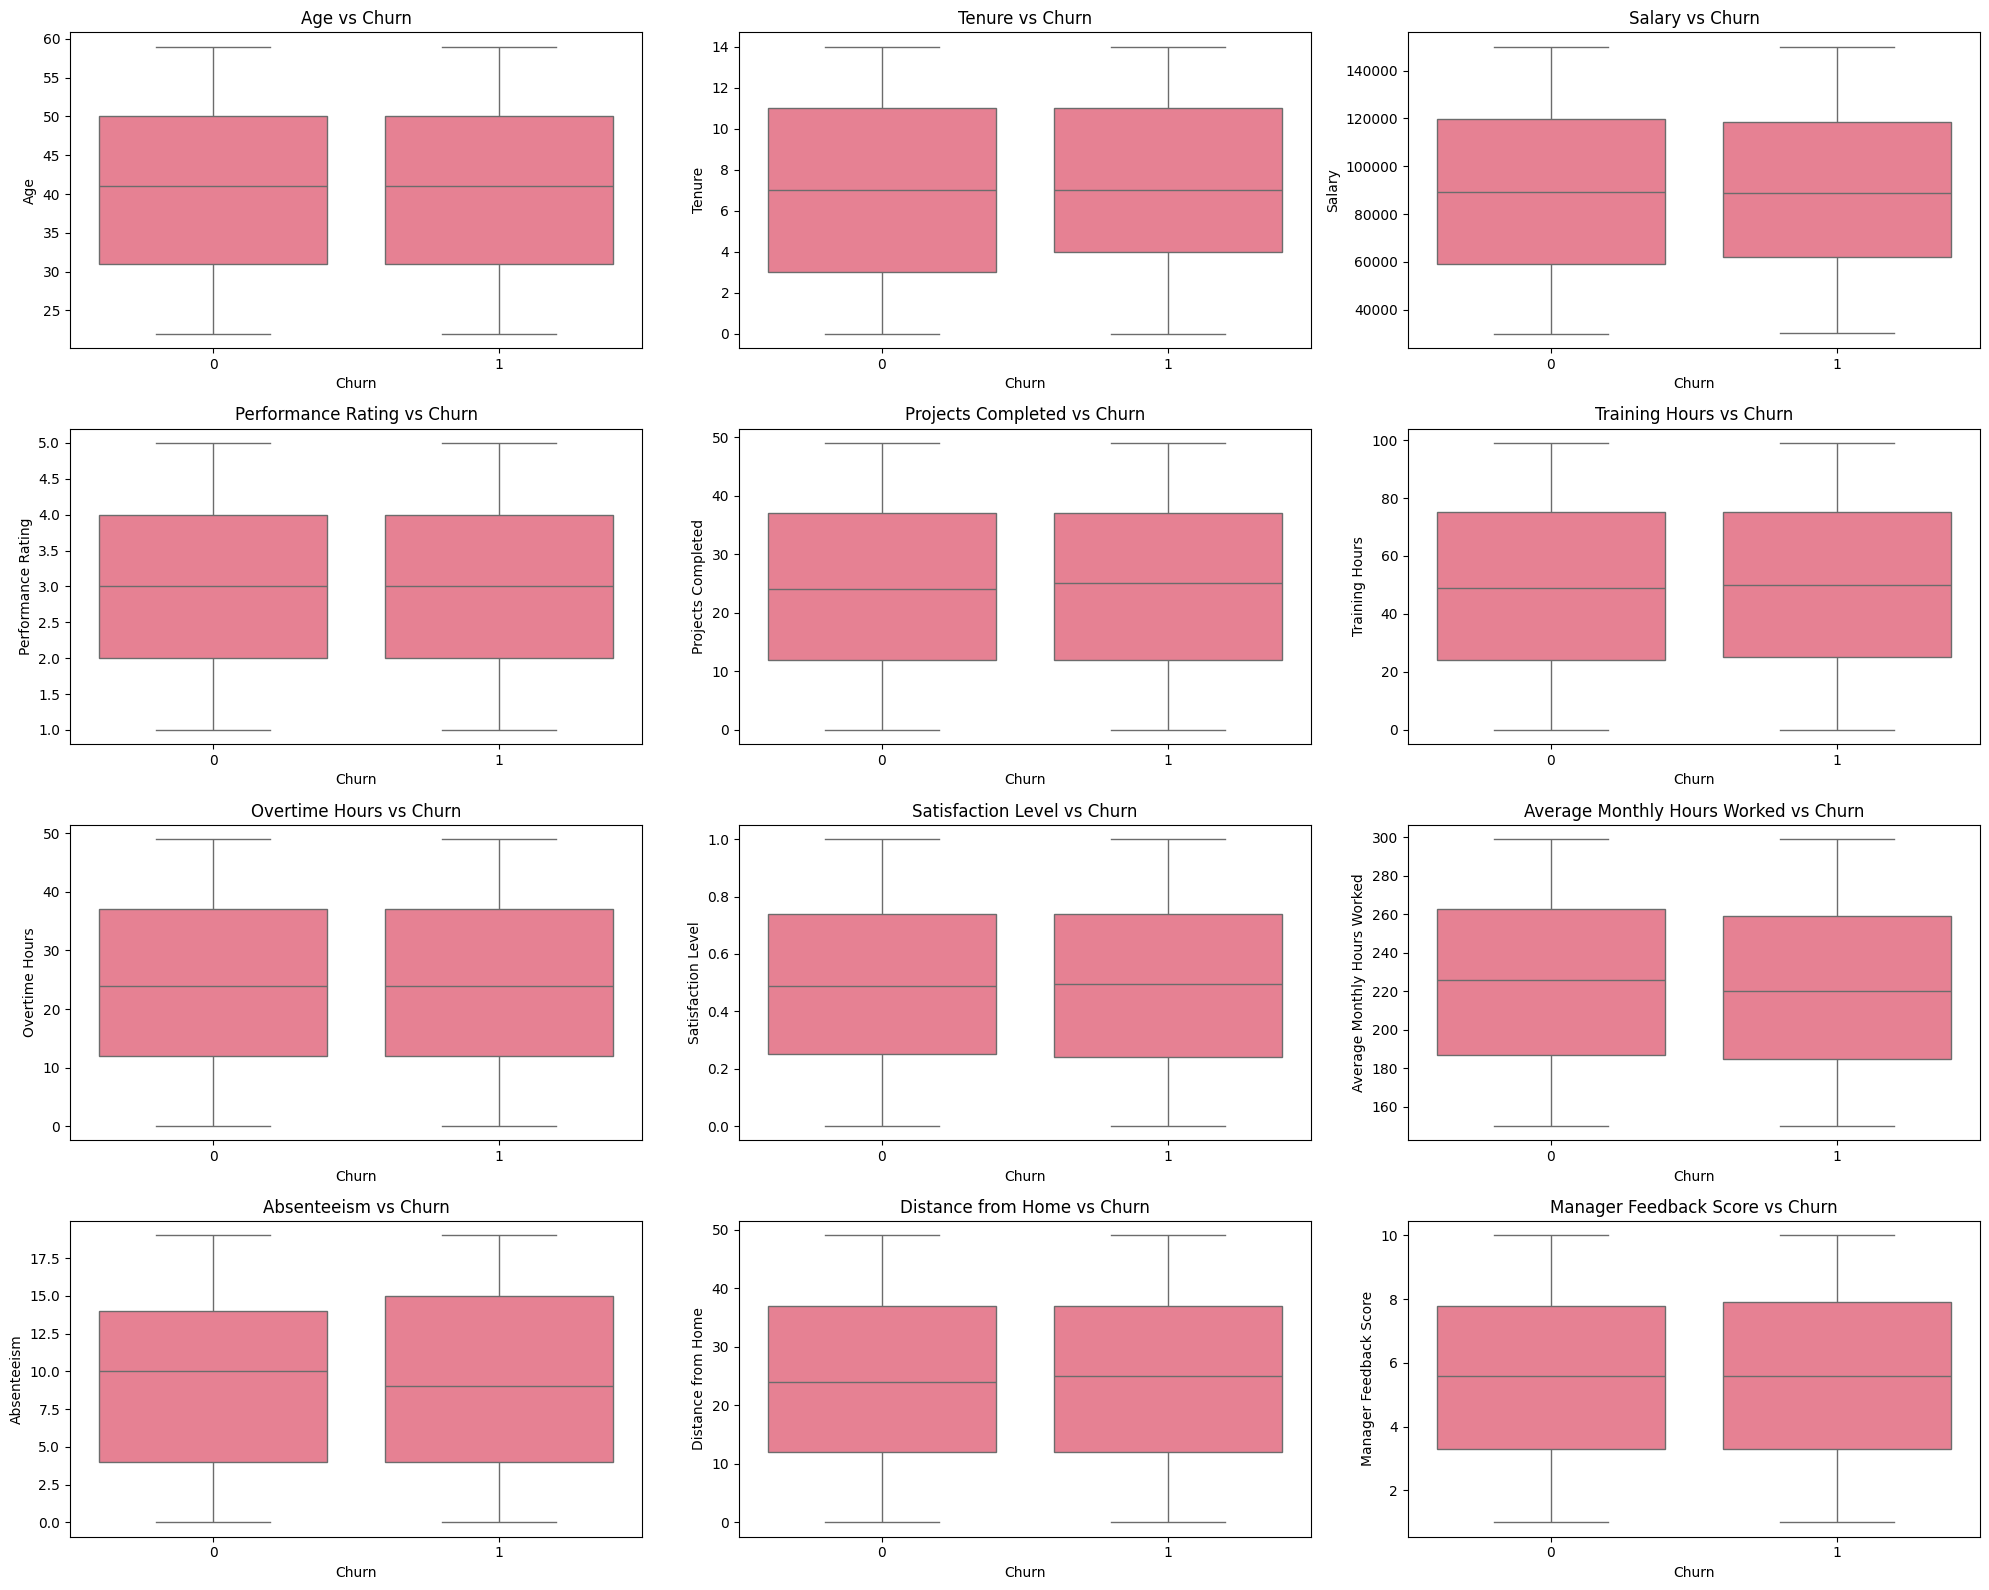

In [ ]:
# Numerical features
numeric_vars = ['Age', 'Tenure', 'Salary', 'Performance Rating', 'Projects Completed', 
               'Training Hours', 'Overtime Hours', 'Satisfaction Level', 
               'Average Monthly Hours Worked', 'Absenteeism', 'Distance from Home', 
               'Manager Feedback Score']

fig, axes = plt.subplots(4, 3, figsize=(20, 16))

for i, var in enumerate(numeric_vars):
    row, col = i // 3, i % 3
    sns.boxplot(data=df, x='Churn', y=var, ax=axes[row, col])
    axes[row, col].set_title(f'{var} vs Churn')

plt.tight_layout()
plt.show()

The boxplot above for continuous variables versus Churn shows that most features have overlapping medians and interquartile ranges (IQRs) across both "No Churn" and "Churn" categories. This confirms that no single continuous variable exhibits a clear, distinct separation based on central tendencies.

While there are slight but subtle differences—such as a marginally wider IQR in the "Churn" group for Satisfaction Level, Average Monthly Hours Worked, and Absenteeism—these variations do not yield significant insights. In conclusion, the comparison between the outcome and these features does not provide substantial evidence regarding employee attrition.

The final graphical analysis with groupings, as depicted below, also reveals no new insights, reinforcing the lack of clear patterns associated with Churn.

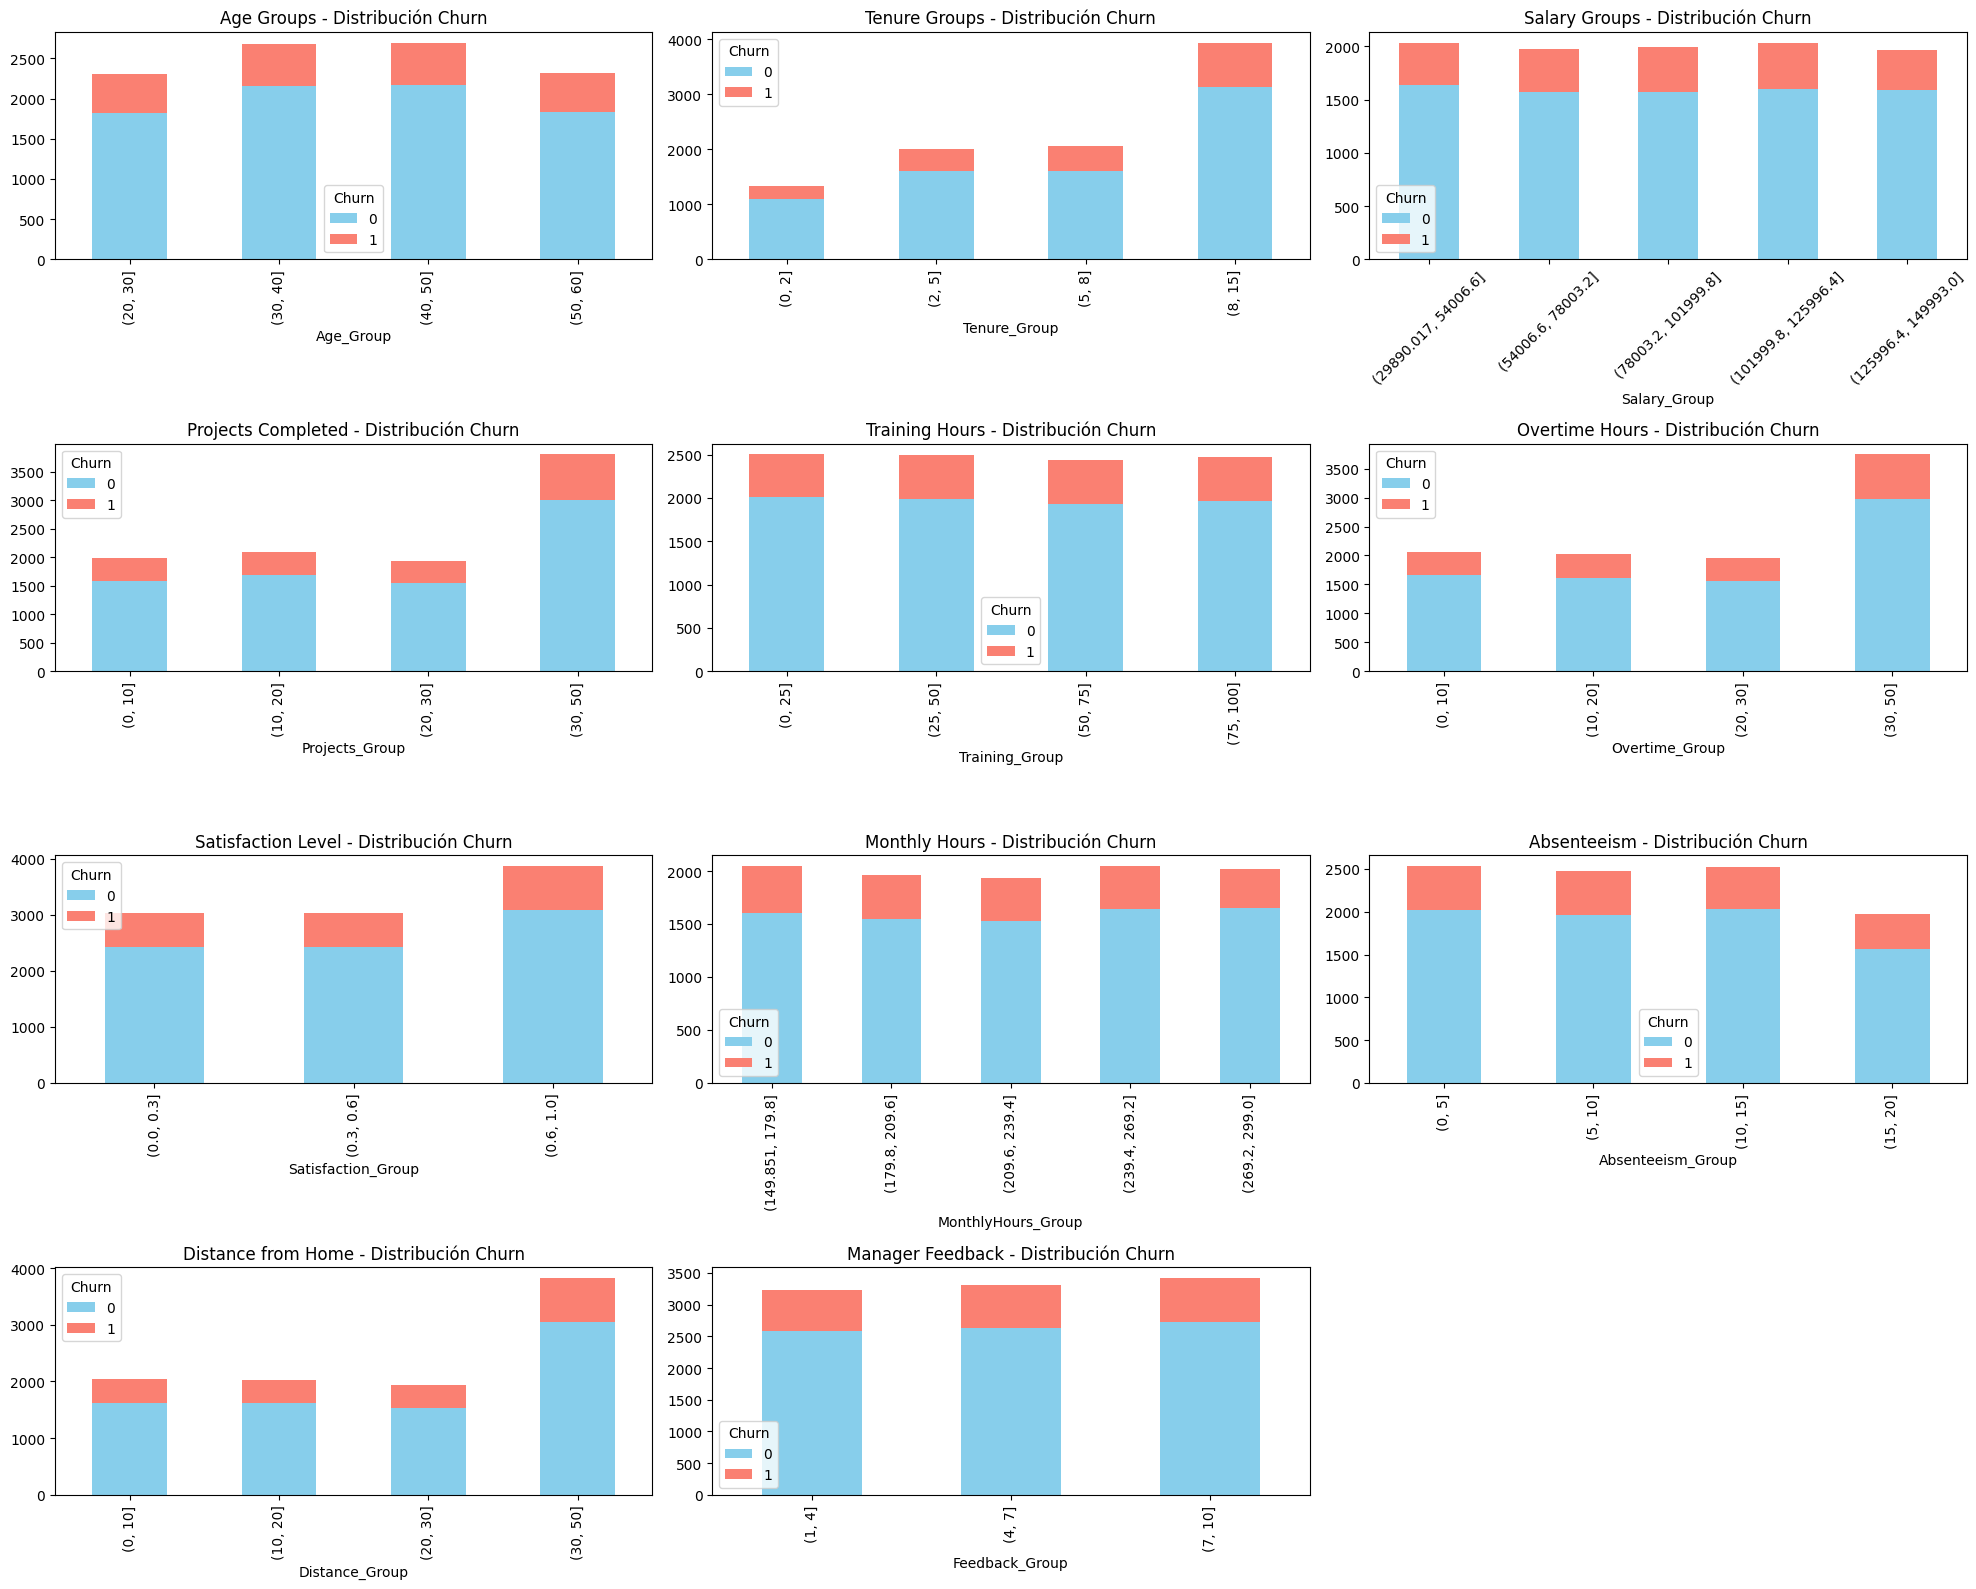

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16))

# Age bins
df['Age_Group'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60])
age_cross = pd.crosstab(df['Age_Group'], df['Churn'])
age_cross.plot(kind='bar', stacked=True, ax=axes[0,0], color=['skyblue', 'salmon'])
axes[0,0].set_title('Age Groups - Distribución Churn')

# Tenure bins
df['Tenure_Group'] = pd.cut(df['Tenure'], bins=[0, 2, 5, 8, 15])
tenure_cross = pd.crosstab(df['Tenure_Group'], df['Churn'])
tenure_cross.plot(kind='bar', stacked=True, ax=axes[0,1], color=['skyblue', 'salmon'])
axes[0,1].set_title('Tenure Groups - Distribución Churn')

# Salary bins
df['Salary_Group'] = pd.cut(df['Salary'], bins=5)
salary_cross = pd.crosstab(df['Salary_Group'], df['Churn'])
salary_cross.plot(kind='bar', stacked=True, ax=axes[0,2], color=['skyblue', 'salmon'])
axes[0,2].set_title('Salary Groups - Distribución Churn')
axes[0,2].tick_params(axis='x', rotation=45)

# Projects Completed bins
df['Projects_Group'] = pd.cut(df['Projects Completed'], bins=[0, 10, 20, 30, 50])
projects_cross = pd.crosstab(df['Projects_Group'], df['Churn'])
projects_cross.plot(kind='bar', stacked=True, ax=axes[1,0], color=['skyblue', 'salmon'])
axes[1,0].set_title('Projects Completed - Distribución Churn')

# Training Hours bins
df['Training_Group'] = pd.cut(df['Training Hours'], bins=[0, 25, 50, 75, 100])
training_cross = pd.crosstab(df['Training_Group'], df['Churn'])
training_cross.plot(kind='bar', stacked=True, ax=axes[1,1], color=['skyblue', 'salmon'])
axes[1,1].set_title('Training Hours - Distribución Churn')

# Overtime Hours bins
df['Overtime_Group'] = pd.cut(df['Overtime Hours'], bins=[0, 10, 20, 30, 50])
overtime_cross = pd.crosstab(df['Overtime_Group'], df['Churn'])
overtime_cross.plot(kind='bar', stacked=True, ax=axes[1,2], color=['skyblue', 'salmon'])
axes[1,2].set_title('Overtime Hours - Distribución Churn')

# Satisfaction Level bins
df['Satisfaction_Group'] = pd.cut(df['Satisfaction Level'], bins=[0, 0.3, 0.6, 1.0])
satisfaction_cross = pd.crosstab(df['Satisfaction_Group'], df['Churn'])
satisfaction_cross.plot(kind='bar', stacked=True, ax=axes[2,0], color=['skyblue', 'salmon'])
axes[2,0].set_title('Satisfaction Level - Distribución Churn')

# Monthly Hours bins
df['MonthlyHours_Group'] = pd.cut(df['Average Monthly Hours Worked'], bins=5)
monthly_cross = pd.crosstab(df['MonthlyHours_Group'], df['Churn'])
monthly_cross.plot(kind='bar', stacked=True, ax=axes[2,1], color=['skyblue', 'salmon'])
axes[2,1].set_title('Monthly Hours - Distribución Churn')

# Absenteeism bins
df['Absenteeism_Group'] = pd.cut(df['Absenteeism'], bins=[0, 5, 10, 15, 20])
absenteeism_cross = pd.crosstab(df['Absenteeism_Group'], df['Churn'])
absenteeism_cross.plot(kind='bar', stacked=True, ax=axes[2,2], color=['skyblue', 'salmon'])
axes[2,2].set_title('Absenteeism - Distribución Churn')

# Distance from Home bins
df['Distance_Group'] = pd.cut(df['Distance from Home'], bins=[0, 10, 20, 30, 50])
distance_cross = pd.crosstab(df['Distance_Group'], df['Churn'])
distance_cross.plot(kind='bar', stacked=True, ax=axes[3,0], color=['skyblue', 'salmon'])
axes[3,0].set_title('Distance from Home - Distribución Churn')

# Manager Feedback bins
df['Feedback_Group'] = pd.cut(df['Manager Feedback Score'], bins=[1, 4, 7, 10])
feedback_cross = pd.crosstab(df['Feedback_Group'], df['Churn'])
feedback_cross.plot(kind='bar', stacked=True, ax=axes[3,1], color=['skyblue', 'salmon'])
axes[3,1].set_title('Manager Feedback - Distribución Churn')

axes[3,2].set_visible(False)

plt.tight_layout()
plt.show()

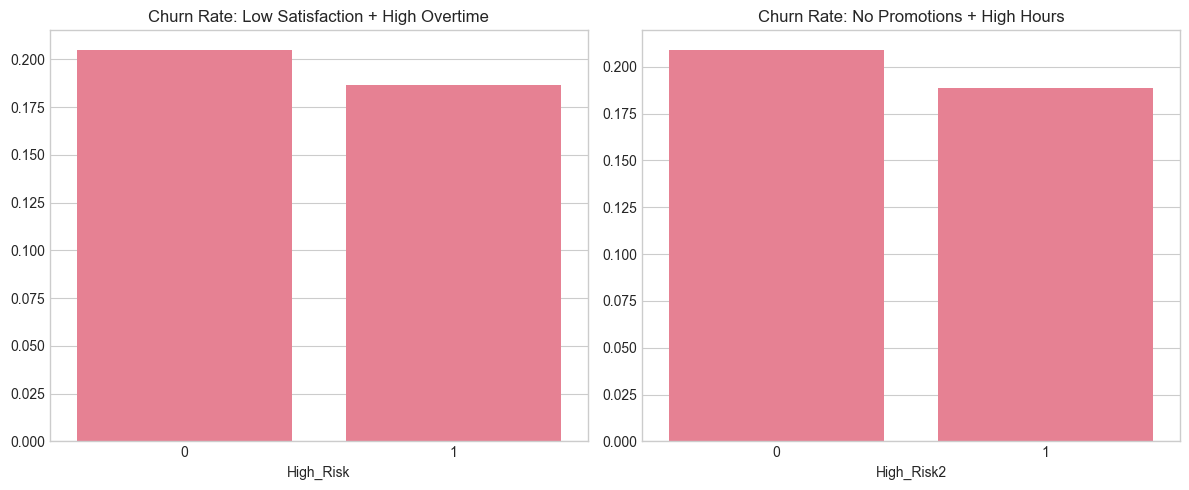

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Employees with low satisfaction and high overtime hours
condition = (df['Satisfaction Level'] < 0.3) & (df['Overtime Hours'] > 30)
df['High_Risk'] = condition.astype(int)
risk_churn = df.groupby('High_Risk')['Churn'].mean()
sns.barplot(x=risk_churn.index, y=risk_churn.values, ax=axes[0])
axes[0].set_title('Churn Rate: Low Satisfaction + High Overtime')

# No promoted employees and  high work burden
condition2 = (df['Promotions'] == 0) & (df['Average Monthly Hours Worked'] > 250)
df['High_Risk2'] = condition2.astype(int)
risk_churn2 = df.groupby('High_Risk2')['Churn'].mean()
sns.barplot(x=risk_churn2.index, y=risk_churn2.values, ax=axes[1])
axes[1].set_title('Churn Rate: No Promotions + High Hours')

plt.tight_layout()
plt.show()

The charts indicate that for both "Low Satisfaction + High Overtime" and "No Promotions + High Hours," the churn rate is lower at around 0.18 (18%) for the high-risk group (Leave) compared to around 0.21 (21%) for the non-high-risk group (Stay). This 3 percentage point decrease suggests that these combinations do not act as significant drivers of turnover and may even be associated with slightly lower churn. This finding aligns with the earlier observation that no single variable or basic two-factor interaction dominates linearly as a driver of employee turnover.

In conclusion, it is required investigation with non-linear models and additional variables is recommended to understand this unexpected pattern and identify the true underlying factors influencing churn.

## Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Employee ID', 'Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=911)

In [57]:
print(f'{'*'*5} Split validation {'*'*5}\n')
print(f'X_train shape: {X_train.shape}')
print(f'X_train shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_train shape: {y_train.shape}')

#num = (y_train.value_counts()*100)/y.value_counts()
print("\nChurn distribution in train:")
print(f'y_train\n{y_train.value_counts(normalize=True)*100}')
print("\nChurn distribution in test:")
print(f'y_test\n{y_test.value_counts(normalize=True)*100}')

***** Split validation *****

X_train shape: (8000, 20)
X_train shape: (2000, 20)
y_train shape: (8000,)
y_train shape: (8000,)

Churn distribution in train:
y_train
Churn
0    79.725
1    20.275
Name: proportion, dtype: float64

Churn distribution in test:
y_test
Churn
0    79.7
1    20.3
Name: proportion, dtype: float64


In this step, considering the moderate class imbalance, a stratified split was applied to the entire dataset. This approach ensures that both the training and test subsets maintain the same class distribution as the original data, preserving representativeness and preventing sampling bias in the subsequent stages of the Machine Learning workflow.

## Preprocessing

### Missing and Null Values

No missing values were detected in the dataset. The initial inspection using df.info() and subsequent verification with df.isna() confirmed that all features are complete. Additionally, no null, invalid, or outlier values requiring imputation were observed during the exploratory phase. Therefore, no data cleaning actions are needed at this stage, and the analysis proceeds to the next steps.

### Outliers Handling